### Direct links to results
[Multi-task profile model performance across all 10 folds](#multitask-fold)

[Single-task profile model performance across all 10 folds](#singletask-fold)

[Fine-tuned multi-task profile model task-specific performance](#finetune-multitask-task)

In [1]:
import h5py
import numpy as np
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
import json
import os
import tqdm
tqdm.tqdm_notebook()

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
# Define parameters/fetch arguments
tf_name = os.environ["TFM_RESULTS_TF_NAME"]
num_tasks = int(os.environ["TFM_RESULTS_NUM_TASKS"])
best_multitask_fold = int(os.environ["TFM_RESULTS_BEST_MULTITASK_FOLD"])
best_singletask_folds = [int(x) for x in os.environ["TFM_RESULTS_BEST_SINGLETASK_FOLDS"].split(",")]
   
print("TF name: %s" % tf_name)
print("Number of tasks: %d" % num_tasks)
print("Best multi-task fold: %d" % best_multitask_fold)
print("Best single-task folds: %s" % " ".join([str(x) for x in best_singletask_folds]))

TF name: E2F6
Number of tasks: 2
Best multi-task fold: 1
Best single-task folds: 10 1


In [4]:
# Whether or not to do min-max normalization for all metrics
min_max = True

In [5]:
preds_base = "/users/amtseng/tfmodisco/results/peak_predictions/"

# Paths for all 10 folds for multi-task profile models
multitask_preds_paths = [
    os.path.join(
        preds_base,
        "multitask_profile",
        "{0}_multitask_profile_fold{1}/{0}_multitask_profile_fold{1}_pred_perf.h5".format(tf_name, fold)
    ) for fold in range(1, 11)
]

# Paths for all 10 folds for single-task profile models, for each task
singletask_preds_paths = [
    [
        os.path.join(
            preds_base,
            "singletask_profile",
            "{0}_singletask_profile_fold{1}/task_{2}/{0}_singletask_profile_task{2}_fold{1}_pred_perf.h5".format(
                tf_name, fold, task_index
            )
        ) for fold in range(1, 11)
    ] for task_index in range(num_tasks)
]

# Path for fine-tuned multi-task profile model
multitask_finetuned_preds_path = os.path.join(
    preds_base,
    "multitask_profile_finetune",
    "{0}_multitask_profile_finetune_fold{1}/{0}_multitask_profile_finetune_fold{1}_pred_perf.h5".format(
        tf_name, best_multitask_fold
    )
)

# Paths for fine-tuned single-task profile models, for each task
singletask_finetuned_preds_paths = [
    os.path.join(
        preds_base,
        "singletask_profile_finetune",
        "{0}_singletask_profile_finetune_fold{1}/task_{2}/{0}_singletask_profile_finetune_task{2}_fold{1}_pred_perf.h5".format(
            tf_name, fold, task_index
        )
    ) for task_index, fold in enumerate(best_singletask_folds)
]

# Path for upper-bound and lower-bound performance metrics
perf_bounds_path = "/users/amtseng/tfmodisco/results/performance_bounds/{0}_performance_bounds.h5".format(tf_name)

# File specifications (including peak files)
files_spec_json = "/users/amtseng/tfmodisco/data/processed/ENCODE/config/{0}/{0}_training_paths.json".format(tf_name)
with open(files_spec_json, "r") as f:
    files_spec = json.load(f)

# Chromosome split definition (i.e. test set chromosomes)
chrom_splits_json = "/users/amtseng/tfmodisco/data/processed/ENCODE/chrom_splits.json"
with open(chrom_splits_json, "r") as f:
    chrom_splits = json.load(f)
all_fold_test_chroms = [
    chrom_splits[str(fold)]["test"] for fold in range(1, 11)
]
best_multitask_fold_test_chroms = chrom_splits[str(best_multitask_fold)]["test"]
best_singletask_fold_test_chroms = [chrom_splits[str(fold)]["test"] for fold in best_singletask_folds]

In [6]:
input_length = 2114
profile_length = 1000

### Import peak coordinates for each task
For each task, import the set of peaks belonging to that task. This allows us to get a set of indices for coordinates in the saved predictions/performance files that correspond to each task.

In [7]:
# Read in tables containing the peak coordinates, padded to `input_length`
task_coords = []
assert len(files_spec["peak_beds"]) == num_tasks
for peak_bed_path in files_spec["peak_beds"]:
    table = pd.read_csv(
        peak_bed_path, sep="\t", header=None,  # Infer compression
        names=[
            "chrom", "peak_start", "peak_end", "name", "score",
            "strand", "signal", "pval", "qval", "summit_offset"
        ]
    )
    # Add summit location column:
    table["summit"] = table["peak_start"] + table["summit_offset"]
    
    # Add start and end columns, at proper length
    table["start"] = table["summit"] - (input_length // 2)
    table["end"] = table["start"] + input_length
    
    task_coords.append(table[["chrom", "start", "end"]])

### Helper functions
For subsetting predictions/performance metrics to peak subsets, extracting performance metrics, and plotting

In [8]:
def subset_coord_inds(superset_coords, subset_coords):
    """
    Both `superset_coords` and `subset_coords` are Pandas DataFrames of
    coordinates. This will return the indices within `superset_coords`
    (indices being the 0-indexed row numbers) that correspond to the
    coordinates in `subset_coords`. Returns a sorted NumPy array of indices.
    Note that if there are duplicates in either set of coordinates, they
    will be dropped (i.e. the returned indices will be unique).
    """
    inds = superset_coords.reset_index().drop_duplicates(["chrom", "start", "end"]).merge(
            subset_coords.reset_index(), on=["chrom", "start", "end"]
        ).sort_values("index_y")["index_x"].values
    return np.sort(inds)

In [9]:
def compute_cross_entropy(nlls, profiles):
    """
    Computes the cross entropy from the log probability portion of the NLL
    by adding back log(N!/x1!...xk!) and dividing by the true counts.
    Arguments:
        `nlls`: An N x T array of NLLs (strands averaged)
        `profiles`: An N x T x O x 2 corresponding array of true profile counts
            (that were used to compute the NLLs)
    Returns an N x T array of NLL log probabilities.
    """
    counts = np.sum(profiles, axis=2)
    log_n_fact = scipy.special.gammaln(counts + 1)
    log_x_fact = scipy.special.gammaln(profiles + 1)
    log_x_fact_sum = np.sum(log_x_fact, axis=2)
    diff = np.mean(log_n_fact + log_x_fact_sum, axis=2)  # Shape: N x T
    return (nlls + diff) / np.mean(counts, axis=2)

In [10]:
def extract_performance_metrics(pred_perf_path, coord_sets=None, task_inds=None):
    """
    Extracts the set of performance metrics from a saved predictions/performance
    HDF5 file. If specified, filters for coordinates that are in `coord_sets`.
    `coord_sets` is a list of coordinate DataFrames, and a set of metrics will
    be fetched for each table of coordinates provided. Otherwise, will simply
    return all coordinates available (i.e. only one coordinate set with all
    coordinates). If `task_inds` is specified, it must be a list of indices
    parallel to `coord_sets`. For each coordinate set, the metrics extracted
    will be for that task index only. If unspecified, the average over all tasks
    is retained for each coordinate set.
    Returns a dictionary of the following form:
        `nll`: [
            <NLL vector for coord set 1>
            <NLL vector for coord set 2>
            ...
        ],
        `count_mse`: [
            <MSE scalar for coord set 1>
            <MSE scalar for coord set 2>
            ...
        ]
        ...
    """
    result = {}
    
    reader = h5py.File(pred_perf_path, "r")
    coord_reader = reader["coords"]
    pred_reader = reader["predictions"]
    perf_reader = reader["performance"]
    
    # First, get the set of indices within the HDF5 predictions/performance that
    # correspond to the given coordinate sets
    if coord_sets is None:
        subset_inds = [np.arange(perf_reader["nll"].shape[0])]  # The entire vector
    else:
        # Import the DataFrame of coordinates in this HDF5
        pred_perf_coords = pd.DataFrame(
            data={
                "chrom": coord_reader["coords_chrom"][:].astype(str),
                "start": coord_reader["coords_start"][:],
                "end": coord_reader["coords_end"][:]
            }
        )
        subset_inds = [
            subset_coord_inds(pred_perf_coords, coord_set)
            for coord_set in coord_sets
        ]
    
    # If we didn't specify a task index for each coordinate set, just use
    # all tasks; either way, let's get each set of task indices into a
    # NumPy array form
    if task_inds is None:
        task_inds = [np.arange(perf_reader["nll"].shape[1])]
    else:
        task_inds = [np.array([i]) for i in task_inds]
        
    # For each performance metric, for each coordinate set/task index, extract
    # the metrics values
    for key in perf_reader.keys():
        metrics_list = []
        for i in range(len(subset_inds)):
            subset = subset_inds[i]
            tasks = task_inds[i]
            
            if len(perf_reader[key].shape) >= 2:  # Profile metric
                metrics_list.append(
                    np.mean(perf_reader[key][subset][:, tasks], axis=1)
                )
            else:  # Count metric
                # If the coordinate set is limited, then we'll need to recompute
                # the count metrics (i.e. MSE and correlations), since these were
                # saved for the entire set
                if coord_sets is None:
                    # No need to recompute
                    metrics_list.append(
                        np.mean(perf_reader[key][tasks])
                    )
                else:
                    log_true_counts = np.ravel(np.log(pred_reader["true_counts"][subset][:, tasks] + 1))
                    log_pred_counts = np.ravel(pred_reader["log_pred_counts"][subset][:, tasks])
                    if key == "count_mse":
                        metrics_list.append(
                            np.mean(np.square(log_true_counts - log_pred_counts))
                        )
                    elif key == "count_pearson":
                        metrics_list.append(
                            scipy.stats.pearsonr(log_true_counts, log_pred_counts)[0]
                        )
                    elif key == "count_spearman":
                        metrics_list.append(
                            scipy.stats.spearmanr(log_true_counts, log_pred_counts)[0]
                        )
                    else:
                        raise ValueError("Unknown count metric key: %s" % key)

        result[key] = metrics_list

    # Compute the cross entropy for the actual performance
    nll_log_probs = []
    for i in range(len(subset_inds)):
        subset = subset_inds[i]
        tasks = task_inds[i]
        
        log_probs = compute_cross_entropy(
            perf_reader["nll"][subset][:, tasks],
            pred_reader["true_profs"][subset][:, tasks]
        )
        nll_log_probs.append(np.mean(log_probs, axis=1))
    result["cross_ent"] = nll_log_probs
    
    reader.close()
    
    # Convert NaNs to 0
    for key in result:
        result[key] = [np.nan_to_num(a) for a in result[key]]
    
    return result

In [11]:
def extract_performance_bounds(perf_bounds_path, input_length, coord_sets=None, task_inds=None):
    """
    Extracts the set of lower and upper bound performance metrics from a saved
    HDF5 file. `input_length` is the lenght of input sequence to use.
    If specified, filters for coordinates that are in `coord_sets`.
    `coord_sets` is a list of coordinate DataFrames, and a set of metrics will
    be fetched for each table of coordinates provided. Otherwise, will simply
    return all coordinates available (i.e. only one coordinate set with all
    coordinates). If `task_inds` is specified, it must be a list of indices
    parallel to `coord_sets`. For each coordinate set, the metrics extracted
    will be for that task index only. If unspecified, the average over all tasks
    is retained for each coordinate set.
    Returns a dictionary of the following form:
        `nll`: [
            (
                <lower-bound NLL vector for coord set 1>,
                <upper-bound NLL vector for coord set 1>
            ),
            (
                <lower-bound NLL vector for coord set 2>,
                <upper-bound NLL vector for coord set 2>
            ),
            
            ...
        ],
        `count_mse`: [
            (
                <lower-bound MSE scalar for coord set 1>,
                <upper-bound MSE scalar for coord set 1>
            ),
            (
                <lower-bound MSE scalar for coord set 2>,
                <upper-bound MSE scalar for coord set 2>
            ),
            ...
        ]
        ...
    """
    result = {}
    
    reader = h5py.File(perf_bounds_path, "r")
    coord_reader = reader["coords"]
    lower_perf_reader = reader["performance_lower"]
    upper_perf_reader = reader["performance_upper"]
    
    # First, get the set of indices within the HDF5 predictions/performance that
    # correspond to the given coordinate sets
    if coord_sets is None:
        subset_inds = [np.arange(lower_perf_reader["nll"].shape[0])]  # The entire vector
    else:
        # Import the DataFrame of coordinates in this HDF5
        perf_coords = pd.DataFrame(
            data={
                "chrom": coord_reader["coords_chrom"][:].astype(str),
                "start": coord_reader["coords_start"][:],
                "end": coord_reader["coords_end"][:]
            }
        )
        
        # Unlike the predictions, the performance bounds are computed solely
        # based on profiles, so their saved coordinates have a different
        # length, although they are centered at the same summit. So we need
        # to re-pad them.
        perf_coords["midpoint"] = (perf_coords["start"] + perf_coords["end"]) // 2
        perf_coords["start"] = perf_coords["midpoint"] - (input_length // 2)
        perf_coords["end"] = perf_coords["start"] + input_length
        del perf_coords["midpoint"]
        
        subset_inds = [
            subset_coord_inds(perf_coords, coord_set)
            for coord_set in coord_sets
        ]
    
    # If we didn't specify a task index for each coordinate set, just use
    # all tasks; either way, let's get each set of task indices into a
    # NumPy array form
    if task_inds is None:
        task_inds = [np.arange(lower_perf_reader["nll"].shape[1])]
    else:
        task_inds = [np.array([i]) for i in task_inds]
        
    # For each performance metric, for each coordinate set/task index, extract
    # the metrics values for lower and upper bound
    for key in lower_perf_reader.keys():
        metrics_list = []
        for i in range(len(subset_inds)):
            subset = subset_inds[i]
            tasks = task_inds[i]
            
            if len(lower_perf_reader[key].shape) >= 2:  # Profile metric
                metrics_list.append(
                    (
                        np.mean(lower_perf_reader[key][subset][:, tasks], axis=1),
                        np.mean(upper_perf_reader[key][subset][:, tasks], axis=1)
                    )
                )
            else:  # Count metric
                # For the performance bounds, we'll use counts metrics as-is without
                # recomputing them; this is because the counts metrics are distributed
                # very uniformly
                metrics_list.append(
                    (
                        np.mean(lower_perf_reader[key][tasks]),
                        np.mean(upper_perf_reader[key][tasks]),
                    )
                )

        result[key] = metrics_list

    # Note that the cross entropy is already part of the saved HDF5,
    # so we don't need to compute it separately here

    reader.close()
    
    # Convert NaNs to 0
    for key in result:
        result[key] = [(np.nan_to_num(p1), np.nan_to_num(p2)) for p1, p2 in result[key]]
    
    return result

In [12]:
def min_max_normalize(lower_arr, query_arr, upper_arr):
    """
    Given three same-size arrays, returns a version of the query array
    in which the array is min-max normalized to the lower and upper
    bounds (i.e. if the lower bound is 0 and the upper bound is 1).
    If the upper bound is not higher than the lower bound, then the
    bounds will be flipped. This is done independently for each entry.
    """
    mini = np.minimum(lower_arr, upper_arr)
    maxi = np.maximum(lower_arr, upper_arr)
    return np.abs((query_arr - mini) / (maxi - mini))

In [13]:
def plot_performances(perf_dict, title=None, cond_labels=None, cond_colors=None):
    """
    Creates plots for a performance dictionary of the following form:
        `nll`: [
            <NLL vector for cond 1>
            <NLL vector for cond 2>
            ...
        ],
        `count_mse`: [
            <MSE scalar for cond 1>
            <MSE scalar for cond 2>
            ...
        ]
        ...
    For profile metrics (i.e. where the metrics are a vector), creates violin
    plots. For count metrics (i.e. where the metrics are a scalar), creates bar
    plots.
    `cond_labels` and `cond_colors` must be arrays parallel to the set of
    vectors or scalars for each metric.
    """
    def create_violins(ax, metrics_list, colors):
        """
        Creates a violin plot on the given instantiated axes.
        `metrics_list` is a list of vectors. `colors` is a parallel
        list of colors for each violin.
        """
        num_perfs = len(metrics_list)
        
        q1, med, q3 = np.stack([
            np.nanpercentile(data, [25, 50, 70], axis=0) for data in metrics_list
        ], axis=1)
        iqr = q3 - q1
        lower_outlier = q1 - (1.5 * iqr)
        upper_outlier = q3 + (1.5 * iqr)

        
        sorted_clipped_data = [  # Remove outliers based on outlier rule
            np.sort(vec[(vec >= lower_outlier[i]) & (vec <= upper_outlier[i])])
            for i, vec in enumerate(metrics_list)
        ]
        
        plot_parts = ax.violinplot(
            sorted_clipped_data, showmeans=False, showmedians=False, showextrema=False
        )
        violin_parts = plot_parts["bodies"]
        for i in range(num_perfs):
            violin_parts[i].set_facecolor(colors[i])
            violin_parts[i].set_edgecolor(colors[i])
            violin_parts[i].set_alpha(0.7)
        
        inds = np.arange(1, num_perfs + 1)
        ax.vlines(inds, q1, q3, color="black", linewidth=5, zorder=1)
        ax.scatter(inds, med, marker="o", color="white", s=30, zorder=2)
        
    num_conds = len(perf_dict["nll"])
    if not cond_colors:
        cond_colors = ["mediumorchid"] * num_conds
    
    # Profile metrics
    for metric_key, metric_name in [
        ("nll", "NLL"), ("cross_ent", "Cross Entropy"), ("jsd", "JSD"), ("profile_mse", "Profile MSE"),
        ("profile_pearson", "Profile Pearson"), ("profile_spearman", "Profile Spearman")
    ]:
        fig, ax = plt.subplots(figsize=(20, 5))
        create_violins(ax, perf_dict[metric_key], cond_colors)
        if title:
            ax.set_title("%s: %s" % (title, metric_name))
        else:
            ax.set_title(metric_name)
        if cond_labels:
            ax.set_xticks(np.arange(1, num_conds + 1))
            ax.set_xticklabels(cond_labels)
        plt.show()
        print("Average values: " + " ".join([("%.3f" % np.nanmean(arr)) for arr in perf_dict[metric_key]]))

    # Count metrics
    for metric_key, metric_name in [
        ("count_mse", "Count MSE"), ("count_pearson", "Count Pearson"), ("count_spearman", "Count Spearman")
    ]:
        fig, ax = plt.subplots(figsize=(20, 5))
        label_locs = np.arange(num_conds)  # Location of labels
        ax.bar(
            label_locs, perf_dict[metric_key], color=cond_colors, alpha=0.7
        )
        if title:
            ax.set_title("%s: %s" % (title, metric_name))
        else:
            ax.set_title(metric_name)
        if cond_labels:
            ax.set_xticks(label_locs)
            ax.set_xticklabels(cond_labels)
        plt.show()
        print("Average values: " + " ".join([("%.3f" % val) for val in perf_dict[metric_key]]))

<a id="multitask-fold"></a>
### Multi-task profile model performance across all 10 folds
A comparison of the test-set performance (averaged across tasks) between:
1. Multi-task profile models trained across all 10 folds
2. A fine-tuned multi-task profile model on the best-performing fold
3. Upper and lower bounds on the best-performing fold

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


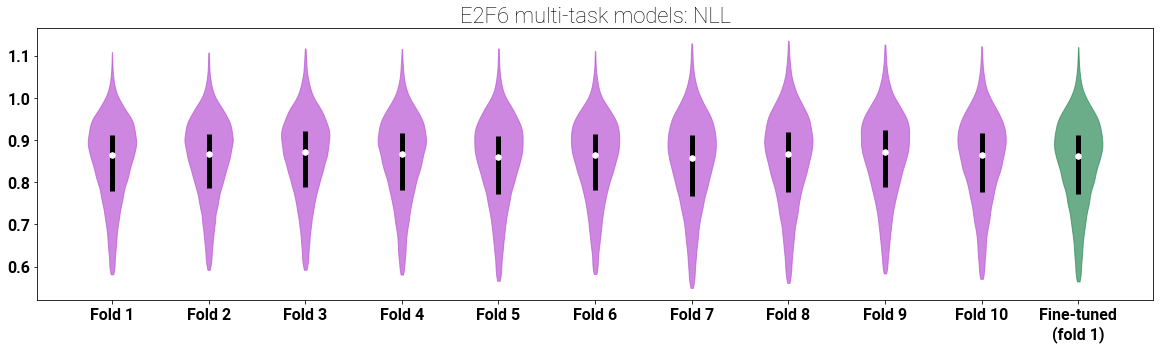

Average values: 0.837 0.842 0.849 0.841 0.834 0.839 0.832 0.843 0.850 0.840 0.835


/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater_equal
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal


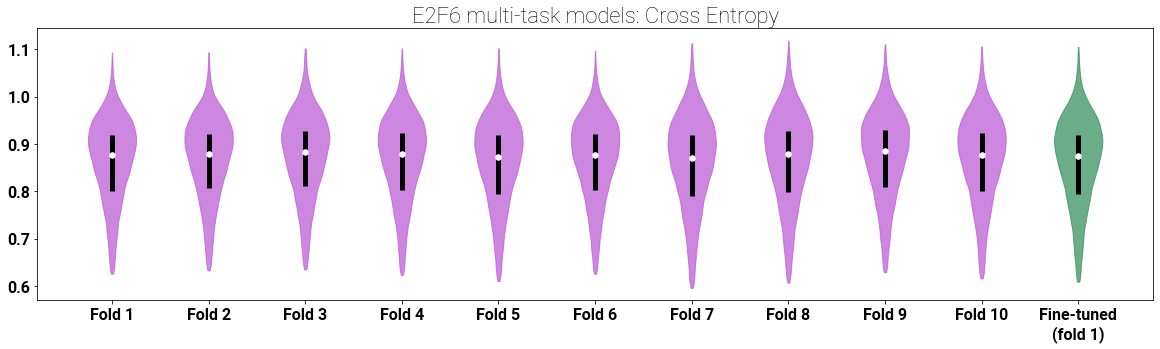

Average values: 0.853 0.857 0.863 0.856 0.850 0.854 0.848 0.857 0.865 0.855 0.851


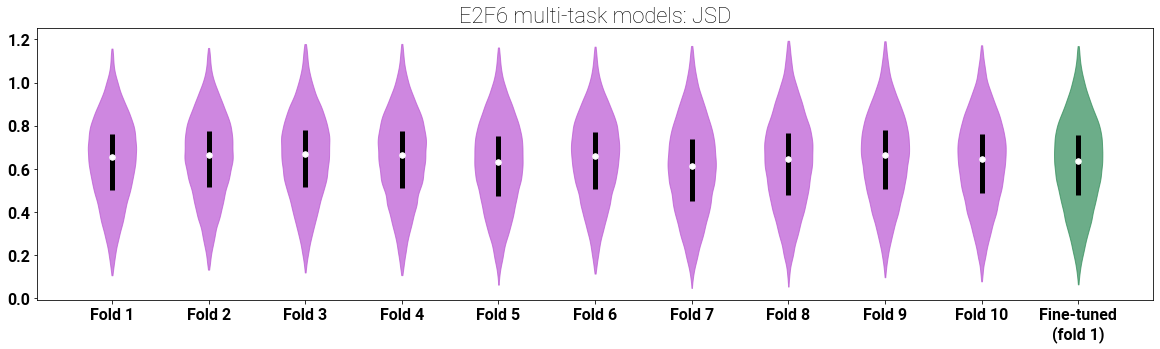

Average values: 0.644 0.659 0.665 0.657 0.629 0.653 0.615 0.644 0.662 0.641 0.632


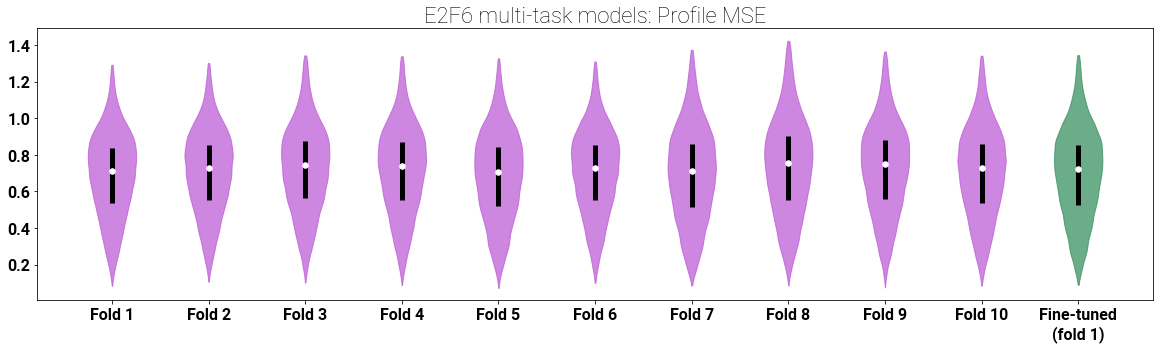

Average values: 0.705 0.725 0.750 0.737 0.707 0.725 0.720 0.771 0.750 0.727 0.719


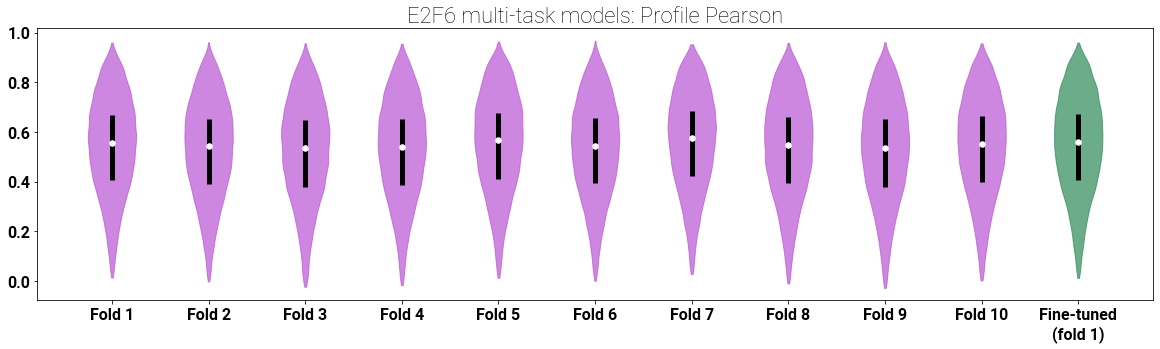

Average values: 0.542 0.528 0.519 0.526 0.550 0.529 0.557 0.533 0.521 0.538 0.546


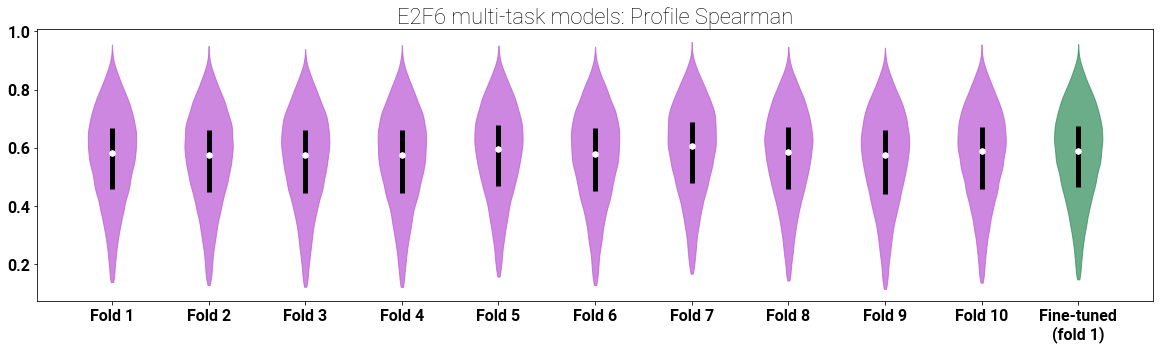

Average values: 0.563 0.554 0.551 0.553 0.574 0.559 0.583 0.564 0.551 0.565 0.569


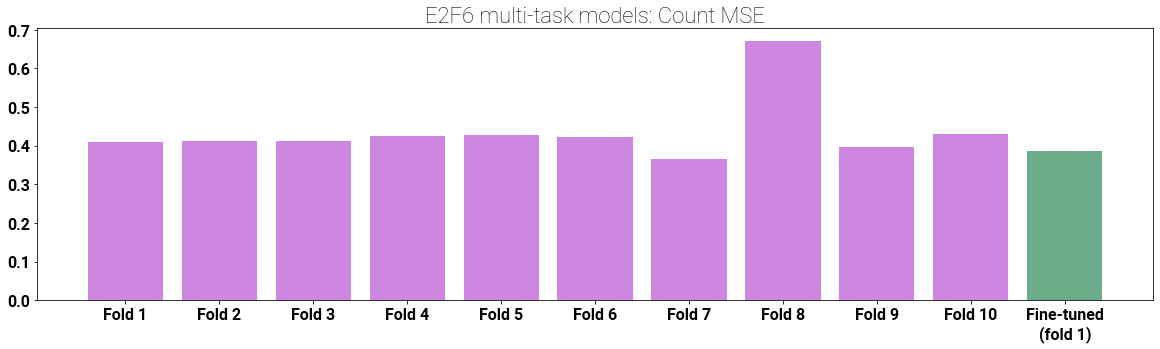

Average values: 0.409 0.411 0.411 0.426 0.429 0.422 0.365 0.670 0.396 0.430 0.387


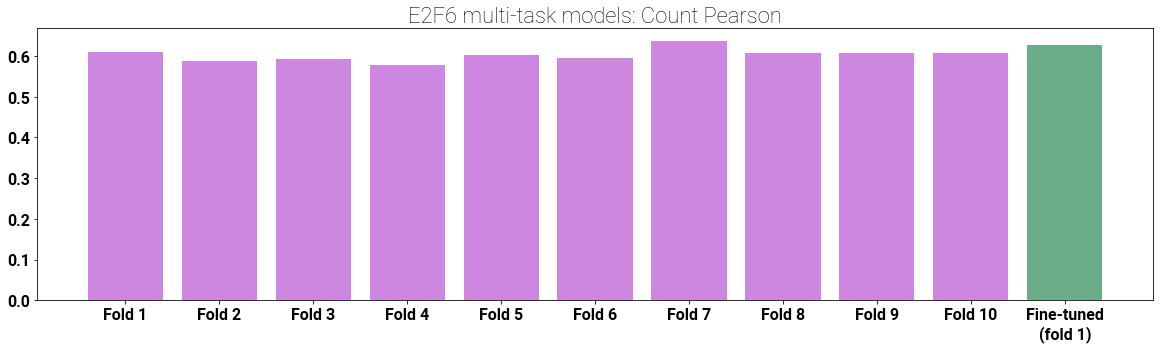

Average values: 0.611 0.587 0.593 0.577 0.603 0.595 0.636 0.607 0.608 0.607 0.627


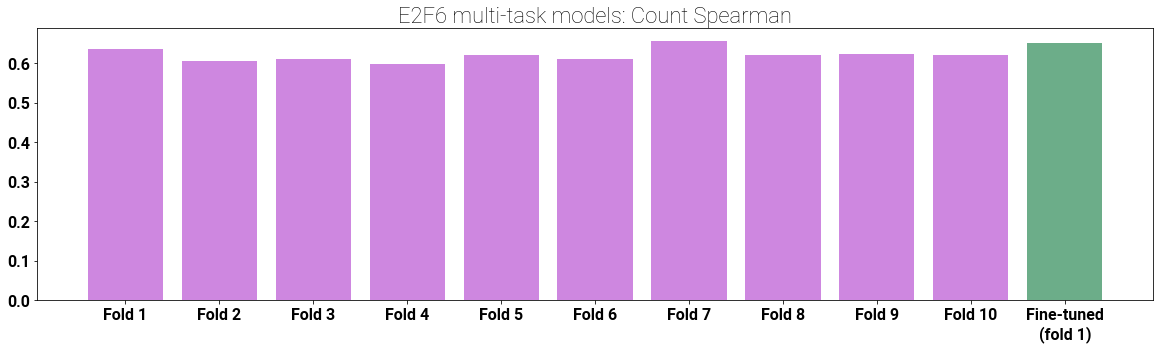

Average values: 0.636 0.605 0.610 0.598 0.620 0.610 0.655 0.622 0.624 0.622 0.651


In [14]:
multitask_bounds_perf_dict = extract_performance_bounds(
    perf_bounds_path, input_length
)
lower_bound_perf_dict = {key : multitask_bounds_perf_dict[key][0][0] for key in multitask_bounds_perf_dict}
upper_bound_perf_dict = {key : multitask_bounds_perf_dict[key][0][1] for key in multitask_bounds_perf_dict}

multitask_perf_dict = {key : [] for key in multitask_bounds_perf_dict}

# 10 folds
for pred_path in multitask_preds_paths:
    perf_dict = extract_performance_metrics(pred_path)
    for key in multitask_perf_dict.keys():
        vals = perf_dict[key][0]
        if min_max and not key.endswith("pearson") and not key.endswith("spearman"):
            vals = min_max_normalize(
                lower_bound_perf_dict[key], vals, upper_bound_perf_dict[key]
            )
        multitask_perf_dict[key].append(vals)

# Fine-tuned
perf_dict = extract_performance_metrics(multitask_finetuned_preds_path)
for key in multitask_perf_dict.keys():
    vals = perf_dict[key][0]
    if min_max and not key.endswith("pearson") and not key.endswith("spearman"):
        vals = min_max_normalize(
            lower_bound_perf_dict[key], vals, upper_bound_perf_dict[key]
        )
    multitask_perf_dict[key].append(vals)
    
# Tack on bounds if not min-max normalized
if not min_max:
    for key in multitask_perf_dict.keys():
        multitask_perf_dict[key] = \
            [lower_bound_perf_dict[key]] + multitask_perf_dict[key] + [upper_bound_perf_dict[key]]

if min_max:
    cond_labels, cond_colors = [], []
else:
    cond_labels, cond_colors = ["Randomized"], ["coral"]
cond_labels += [("Fold %d" % i) for i in range(1, 11)]
cond_labels += ["Fine-tuned\n(fold %d)" % best_multitask_fold]
cond_colors += (["mediumorchid"] * 10) + ["seagreen"]
if not min_max:
    cond_labels += ["Pseudoreps"]
    cond_colors += ["slateblue"]
plot_performances(
    multitask_perf_dict,
    title=("%s multi-task models" % tf_name),
    cond_labels=cond_labels,
    cond_colors=cond_colors
)

del multitask_perf_dict

<a id="singletask-fold"></a>
### Single-task profile model performance across all 10 folds
**For each task**, a comparison of the test-set performance between:
1. Single-task profile models trained across all 10 folds
2. A fine-tuned single-task profile model on the best-performing fold
3. Upper and lower bounds on the best-performing fold

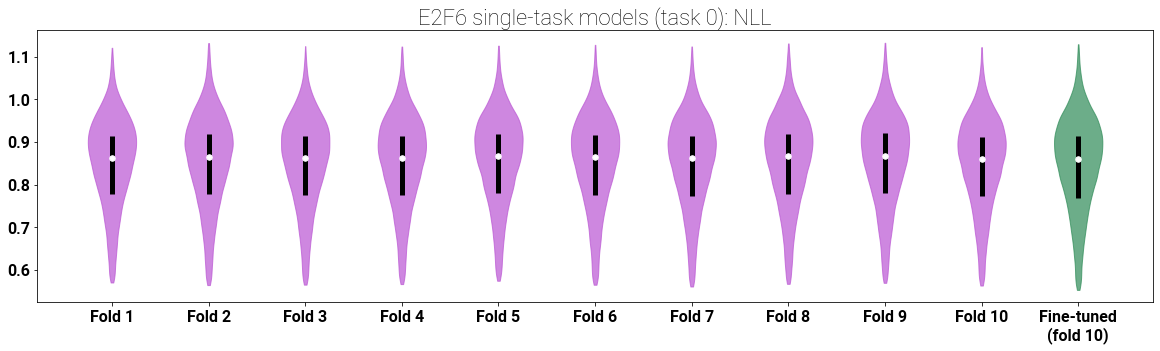

Average values: 0.839 0.842 0.837 0.839 0.844 0.839 0.836 0.844 0.845 0.835 0.834


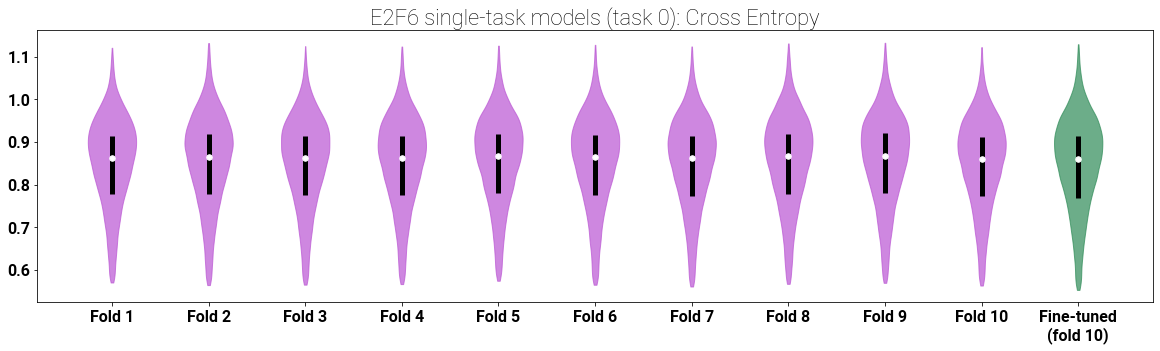

Average values: 0.839 0.842 0.837 0.839 0.844 0.839 0.836 0.844 0.845 0.835 0.834


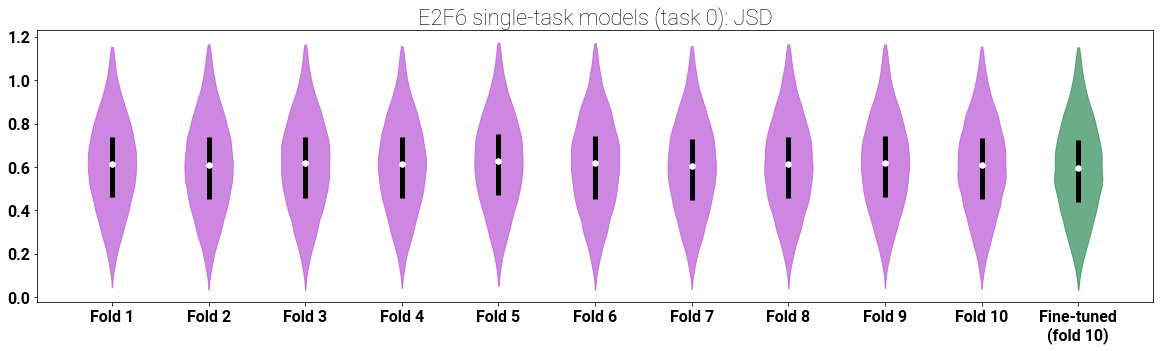

Average values: 0.621 0.620 0.621 0.619 0.634 0.622 0.613 0.625 0.627 0.615 0.606


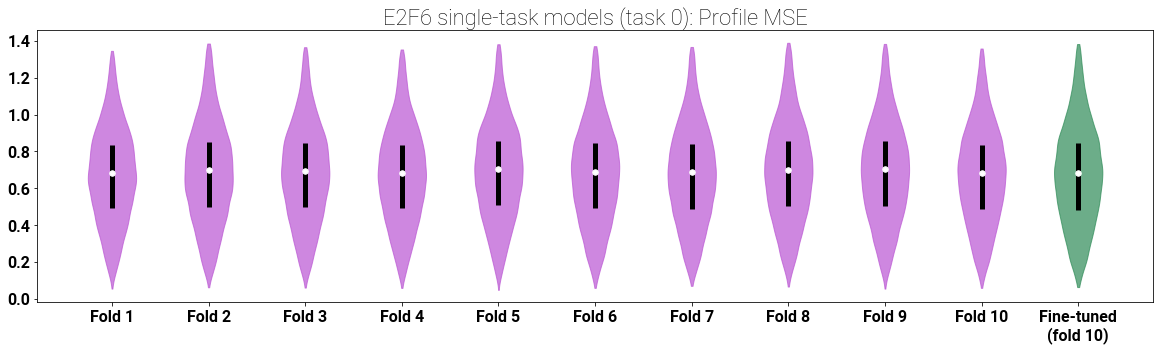

Average values: 0.705 0.728 0.713 0.709 0.729 0.715 0.711 0.730 0.729 0.704 0.709


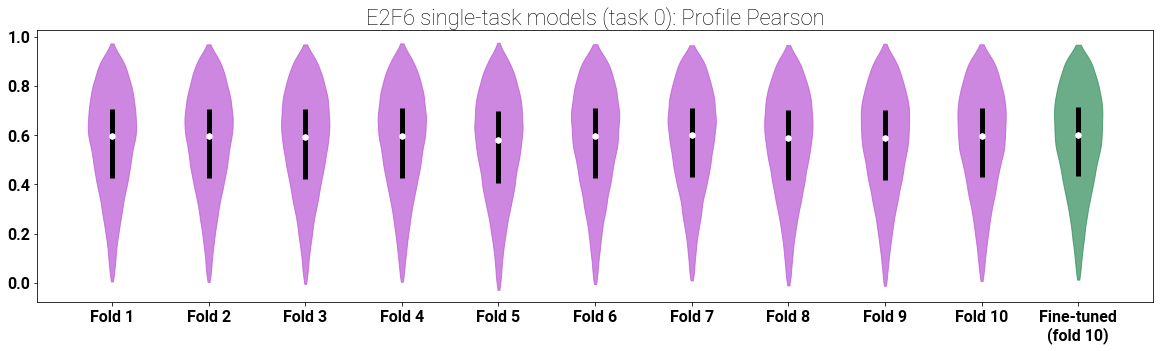

Average values: 0.569 0.568 0.566 0.570 0.557 0.570 0.573 0.561 0.561 0.572 0.576


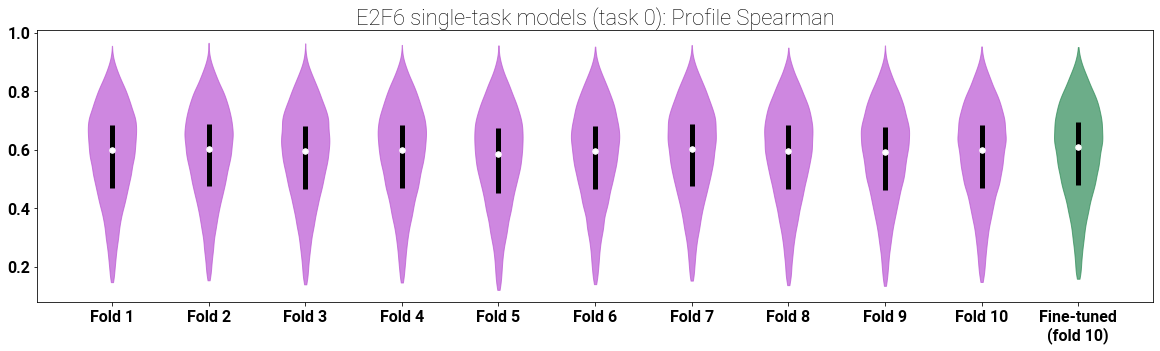

Average values: 0.576 0.580 0.572 0.577 0.562 0.573 0.580 0.574 0.569 0.576 0.585


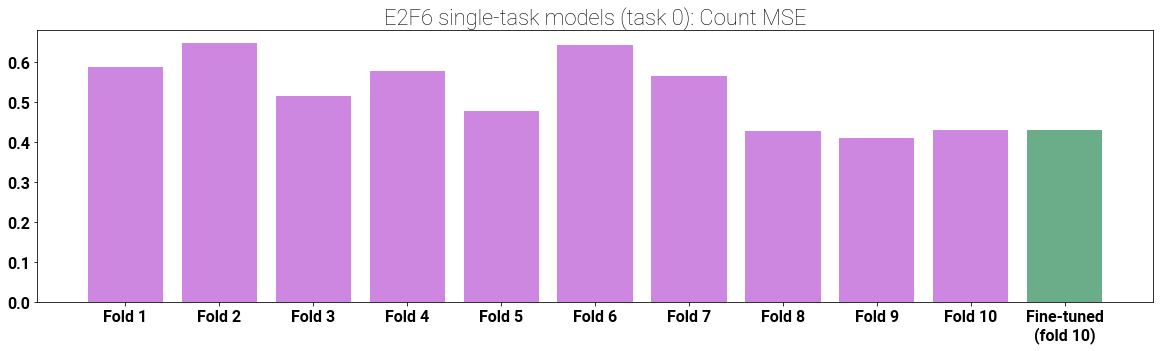

Average values: 0.588 0.648 0.516 0.577 0.478 0.643 0.566 0.428 0.411 0.430 0.432


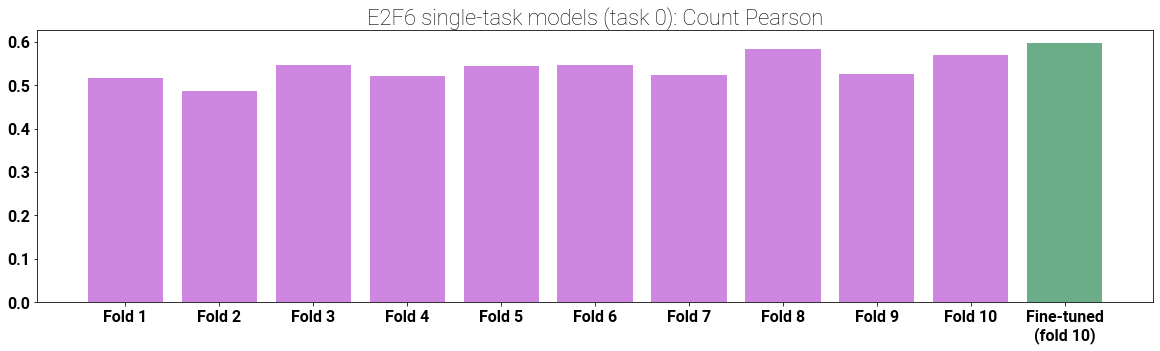

Average values: 0.517 0.486 0.546 0.522 0.544 0.546 0.524 0.584 0.525 0.571 0.597


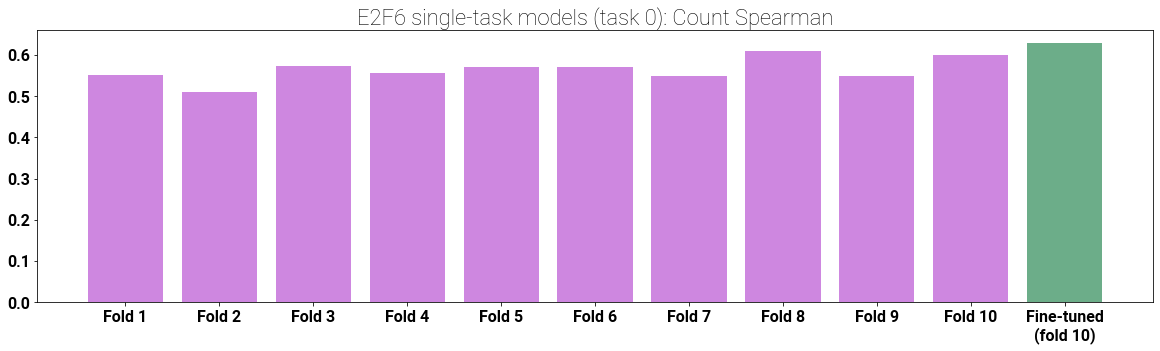

Average values: 0.551 0.509 0.573 0.556 0.571 0.571 0.549 0.609 0.548 0.600 0.628


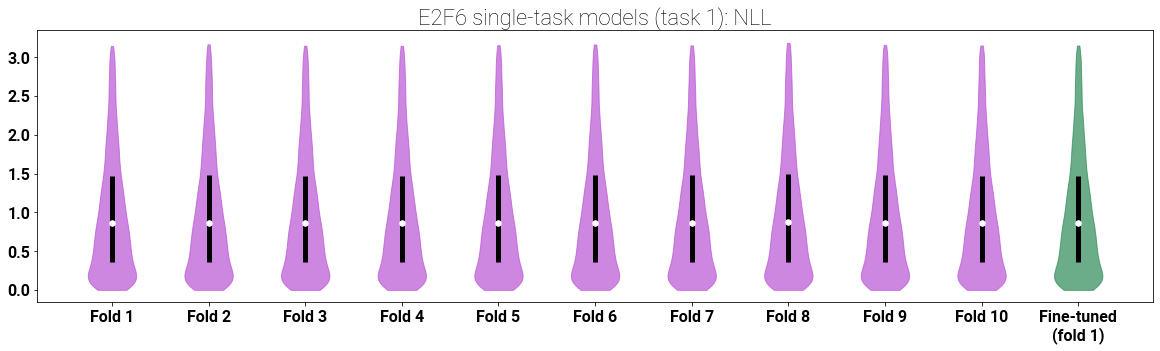

Average values: 1.288 1.293 1.289 1.288 1.288 1.296 1.288 1.305 1.291 1.285 1.287


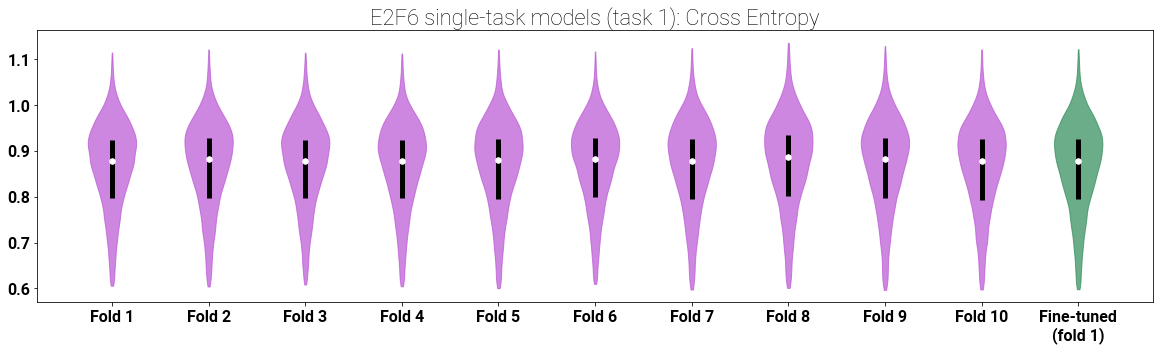

Average values: 0.848 0.851 0.849 0.848 0.849 0.851 0.849 0.857 0.851 0.847 0.847


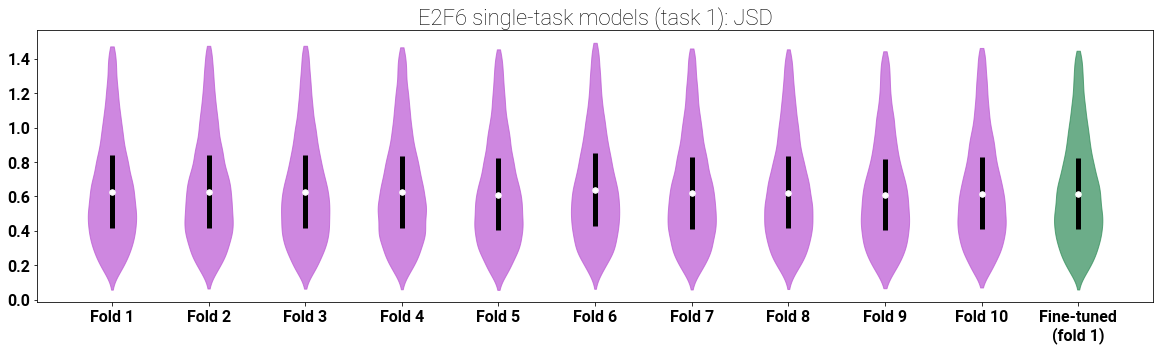

Average values: 0.726 0.725 0.725 0.723 0.709 0.738 0.717 0.721 0.707 0.716 0.713


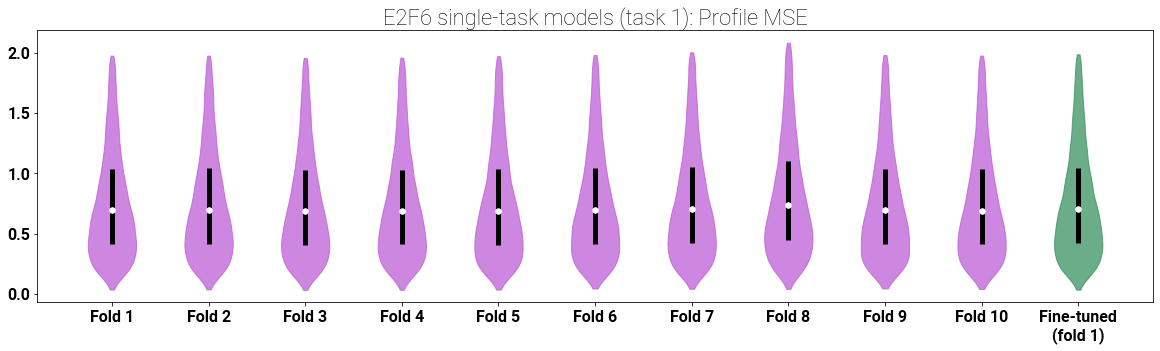

Average values: 0.930 0.935 0.922 0.923 0.923 0.932 0.945 0.979 0.930 0.929 0.938


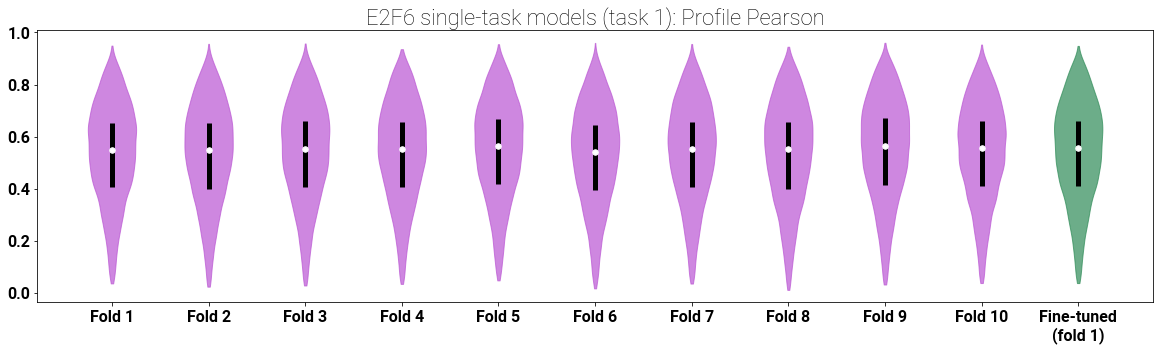

Average values: 0.532 0.529 0.534 0.535 0.544 0.524 0.534 0.531 0.544 0.538 0.538


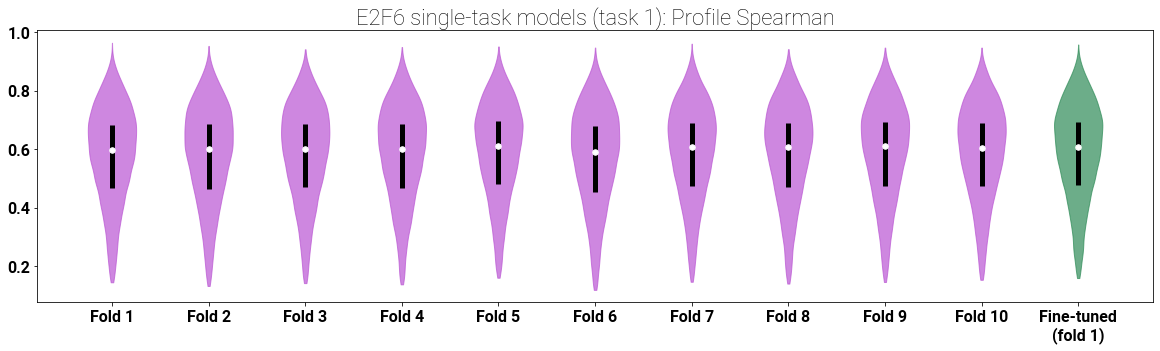

Average values: 0.573 0.571 0.574 0.574 0.584 0.564 0.578 0.577 0.581 0.579 0.581


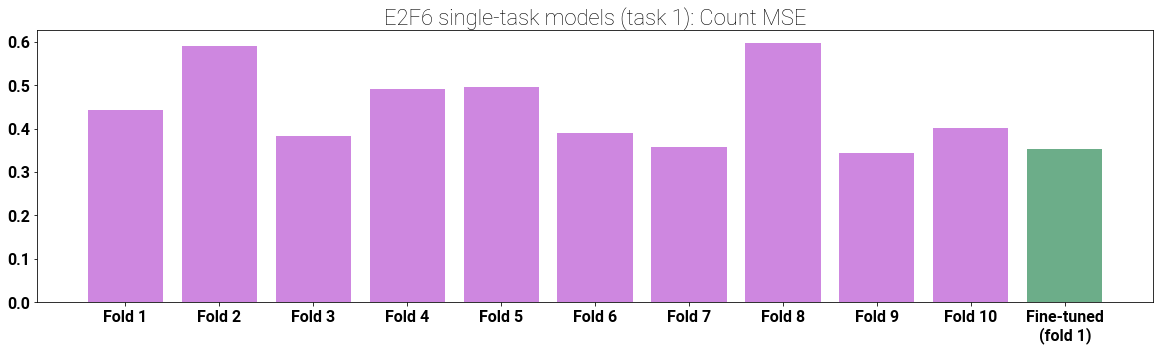

Average values: 0.443 0.590 0.384 0.491 0.496 0.389 0.358 0.596 0.344 0.400 0.353


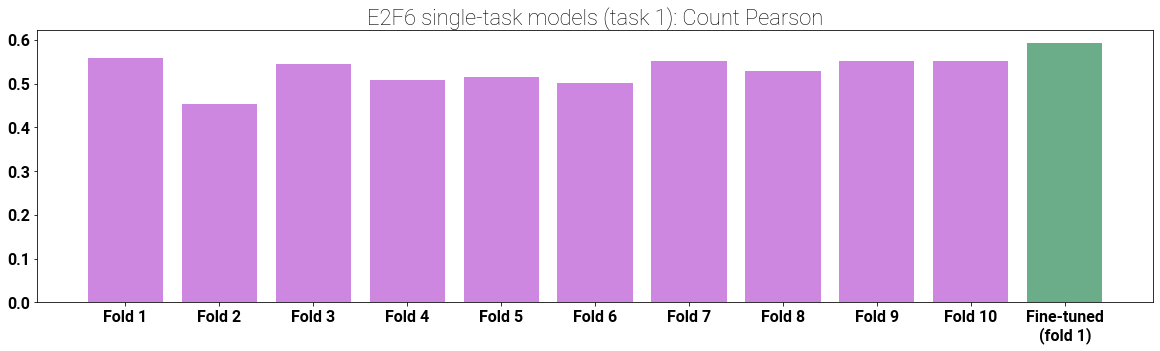

Average values: 0.558 0.454 0.546 0.508 0.516 0.501 0.553 0.528 0.552 0.552 0.592


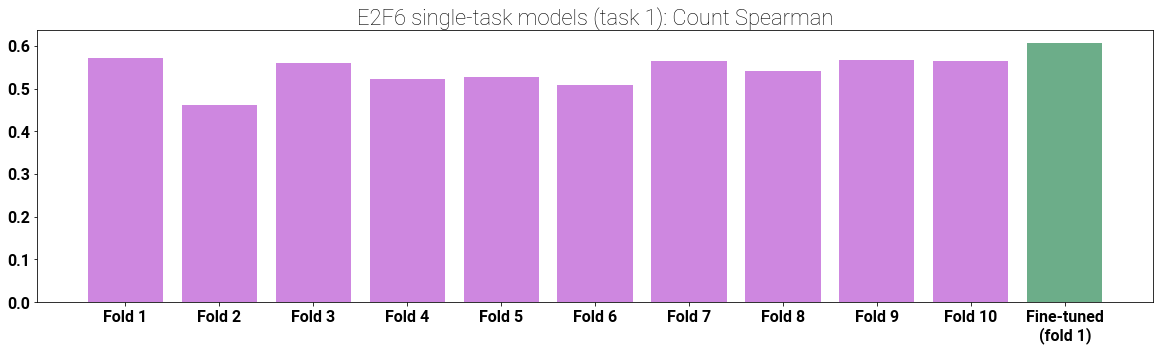

Average values: 0.571 0.461 0.559 0.521 0.528 0.509 0.563 0.541 0.566 0.565 0.606


In [15]:
for task_index in range(len(task_coords)):
    singletask_bounds_perf_dict = extract_performance_bounds(
        perf_bounds_path, input_length,
        coord_sets=[task_coords[task_index]], task_inds=[task_index]
    )
    lower_bound_perf_dict = {key : singletask_bounds_perf_dict[key][0][0] for key in singletask_bounds_perf_dict}
    upper_bound_perf_dict = {key : singletask_bounds_perf_dict[key][0][1] for key in singletask_bounds_perf_dict}

    singletask_perf_dict = {key : [] for key in singletask_bounds_perf_dict}

    # 10 folds
    for pred_path in singletask_preds_paths[task_index]:
        perf_dict = extract_performance_metrics(pred_path)
        # No need to specify specific coordinates or task indices, because
        # single-task model predictions are saved only for that one task
        for key in singletask_perf_dict.keys():
            vals = perf_dict[key][0]
            if min_max and not key.endswith("pearson") and not key.endswith("spearman"):
                vals = min_max_normalize(
                    lower_bound_perf_dict[key], vals, upper_bound_perf_dict[key]
                )
            singletask_perf_dict[key].append(vals)

    # Fine-tuned
    perf_dict = extract_performance_metrics(singletask_finetuned_preds_paths[task_index])
    # No need to specify specific coordinates or task indices, because
    # single-task model predictions are saved only for that one task
    for key in singletask_perf_dict.keys():
        vals = perf_dict[key][0]
        if min_max and not key.endswith("pearson") and not key.endswith("spearman"):
            vals = min_max_normalize(
                lower_bound_perf_dict[key], vals, upper_bound_perf_dict[key]
            )
        singletask_perf_dict[key].append(vals)

    # Tack on bounds if not min-max normalized
    if not min_max:
        for key in singletask_perf_dict.keys():
            singletask_perf_dict[key] = \
                [lower_bound_perf_dict[key]] + singletask_perf_dict[key] + [upper_bound_perf_dict[key]]

    if min_max:
        cond_labels, cond_colors = [], []
    else:
        cond_labels, cond_colors = ["Randomized"], ["coral"]
    cond_labels += [("Fold %d" % i) for i in range(1, 11)]
    cond_labels += ["Fine-tuned\n(fold %d)" % best_singletask_folds[task_index]]
    cond_colors += (["mediumorchid"] * 10) + ["seagreen"]
    if not min_max:
        cond_labels += ["Pseudoreps"]
        cond_colors += ["slateblue"]
    plot_performances(
        singletask_perf_dict,
        title=("%s single-task models (task %d)" % (tf_name, task_index)),
        cond_labels=cond_labels,
        cond_colors=cond_colors
    )

    del singletask_perf_dict

<a id="finetune-multitask-task"></a>
### Fine-tuned multi-task profile model task-specific performance
A comparison of the test-set performance for between each task of a multi-task profile model fine-tuned on the best-performing fold

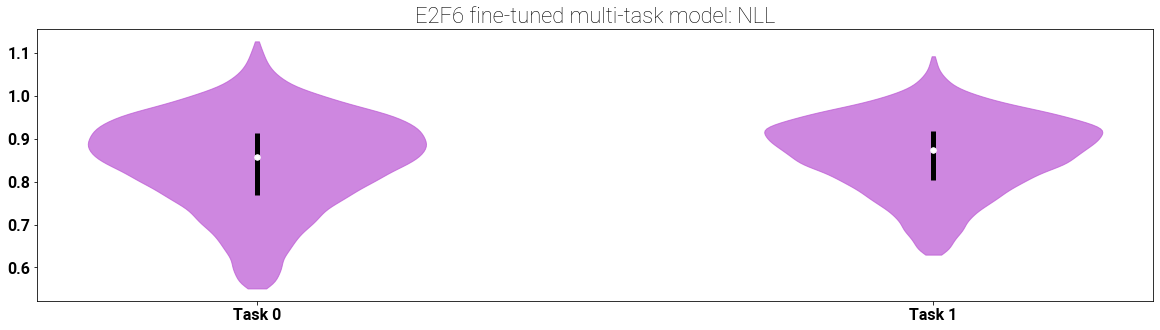

Average values: 0.832 0.856


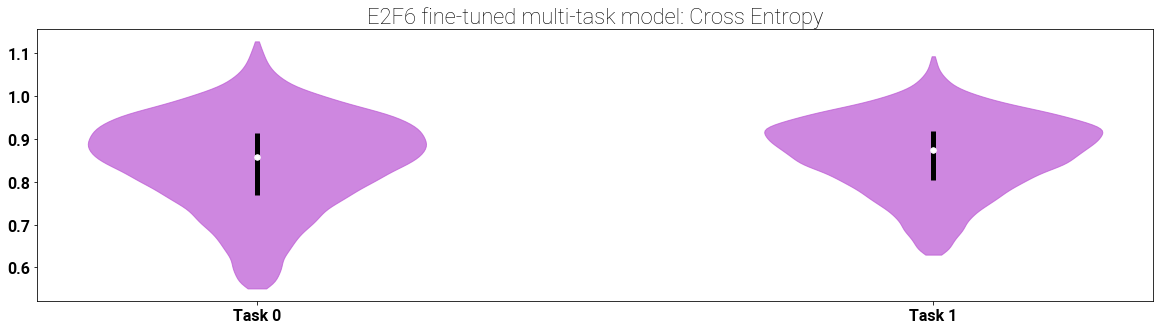

Average values: 0.832 0.856


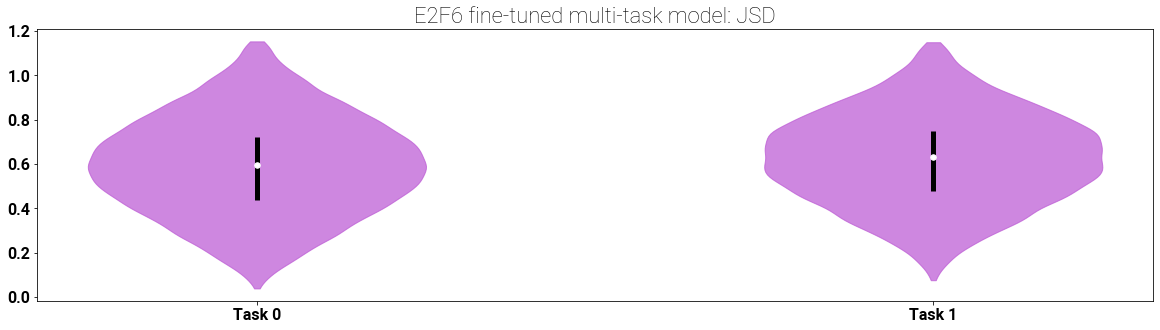

Average values: 0.604 0.632


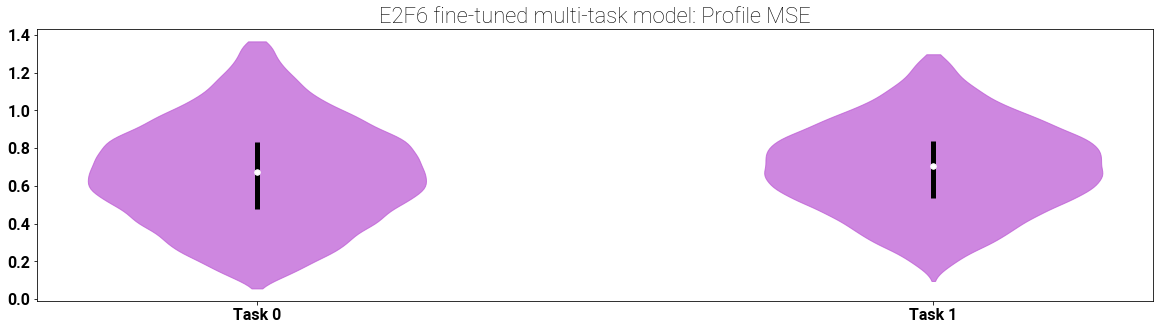

Average values: 0.698 0.717


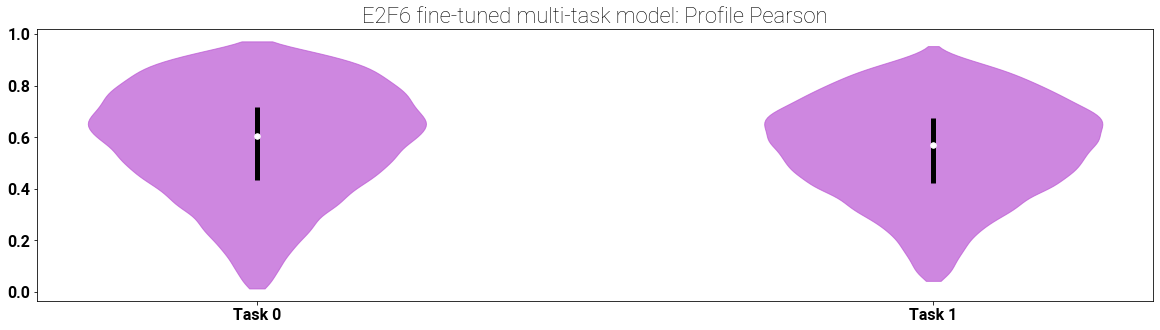

Average values: 0.578 0.551


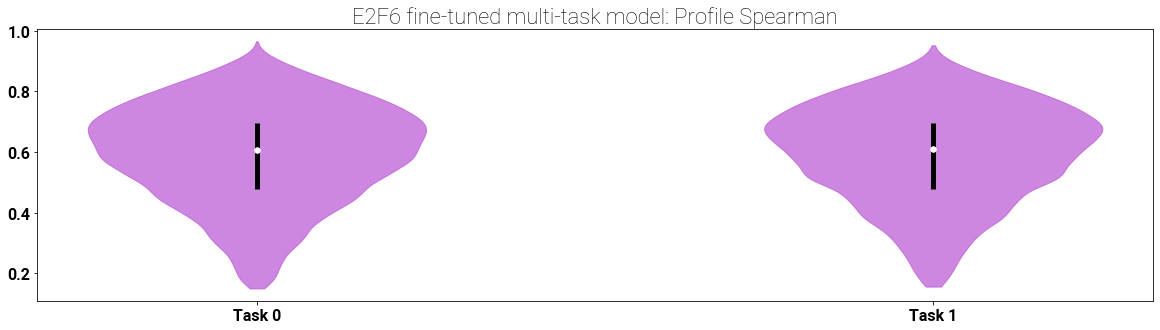

Average values: 0.583 0.583


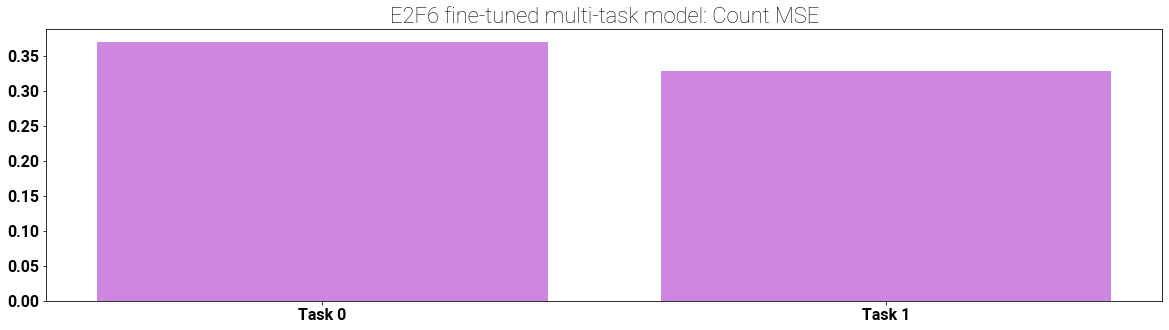

Average values: 0.370 0.328


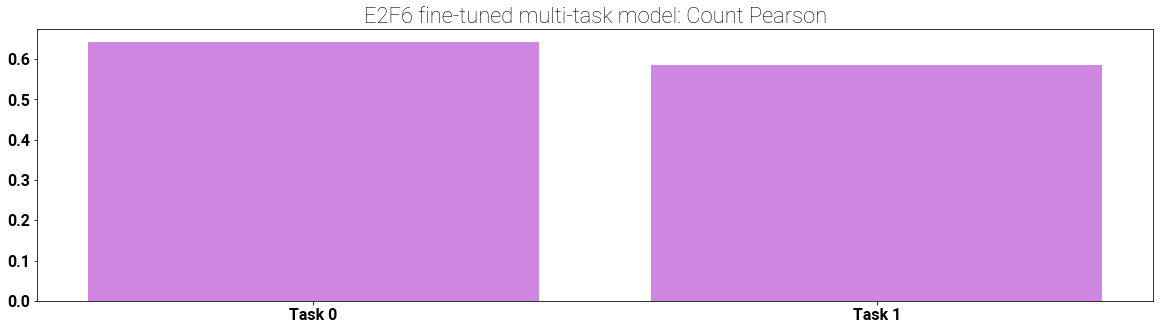

Average values: 0.642 0.586


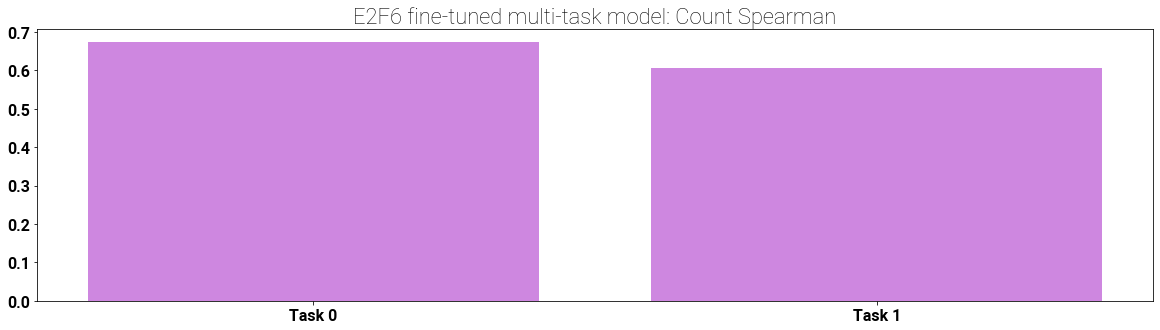

Average values: 0.674 0.605


In [16]:
finetune_multitask_perf_dict = extract_performance_metrics(
    multitask_finetuned_preds_path,
    coord_sets=task_coords,
    task_inds=list(range(len(task_coords)))
)

singletask_bounds_perf_dict = extract_performance_bounds(
    perf_bounds_path, input_length,
    coord_sets=task_coords, task_inds=list(range(len(task_coords)))
)

if min_max:
    for task_index in range(len(task_coords)):
        lower_bound_perf_dict = {key : singletask_bounds_perf_dict[key][task_index][0] for key in singletask_bounds_perf_dict}
        upper_bound_perf_dict = {key : singletask_bounds_perf_dict[key][task_index][1] for key in singletask_bounds_perf_dict}
        
        for key in finetune_multitask_perf_dict.keys():
            if key.endswith("pearson") or key.endswith("spearman"):
                continue
            finetune_multitask_perf_dict[key][task_index] = min_max_normalize(
                lower_bound_perf_dict[key],
                finetune_multitask_perf_dict[key][task_index],
                upper_bound_perf_dict[key]
            )
            
cond_labels = [("Task %d" % i) for i in range(len(task_coords))]
cond_colors = ["mediumorchid"] * len(task_coords)
plot_performances(
    finetune_multitask_perf_dict,
    title=("%s fine-tuned multi-task model" % tf_name),
    cond_labels=cond_labels,
    cond_colors=cond_colors
)

del finetune_multitask_perf_dict